## Quantifying predictive accuracy: Trickier than it seems

### Russell A. Poldrack[1], Grace Huckins[1], and Gael Varoquaux[2]

[1] Department of Psychology and Interdepartmental Neurosciences Program, Stanford University

[2] INRIA

#### Abstract:

There is great interest in developing tools that can predict clinically or scientifically important outcomes from high-dimensional data such as neuroimaging or genomics data.  Our goal in this paper is to highlight several potential pitfalls in predictive modeling. First, we highlight the absolute requirement for any claims of prediction to be tested on data separate from those used to fit the predictive model, which is generally achieved using crossvalidation.  Second, we discuss the use of different possible measures of predictive performance, highlighting the limitations of some commonly used measures and the need for assessment using multiple measures of performance.  Third, we highlight a particular challenge in the application of cross-validation to continuously distributed outcome variables, demonstrating that the naive application of standard cross-validation techniques can result in badly biased results.  Finally, we discuss the use of randomization for null modeling and some challenges in its use.



In [161]:
import numpy,pandas
import seaborn
from sklearn.linear_model import LinearRegression,LogisticRegression,LogisticRegressionCV
from sklearn import model_selection,metrics
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import matplotlib.pyplot as plt

# this imports a function to do balanced cross validation
from get_balanced_folds import BalancedKFold

%matplotlib inline
# %load_ext rpy2.ipython

#### Introduction

There is currently great interest in the development of "biomarkers" for disease, to serve as diagnostic markers or surrogate endpoints. This interest is particular great for neuropsychiatric disorders, given the lack of biological tests for these diseases and their substantial economic and social impact (REF).  This interest is evident in the increasing use of the concept of "prediction" in the field of neuroimaging.  

In this paper we will review a number of challenges that arise in predictive modeling.  Most of these challenges are well known within the machine learning and statistics communities, though even in those literatures some of these points have not been sufficiently emphasized.  


**What does "prediction" mean?**

Let's say that an investigator publishes a report in which they claim to be able to predict a diagnosis of schizophrenia from brain imaging data with 90% accuracy.  Most readers would fairly assume that this implies that the method could be applied in a new sample of individuals with similar accuracy, as this is the common interpretation of the term "prediction".  However, the term "predict" is used in many different ways in the literature, often in ways that would not support the kind of interpretation outlined above.  

**GRACE REVIEW**



**Overfitting and prediction**

The concept of overfitting is well known to machine learning researchers but may be less familiar to those trained in standard statistical methods.  Any dataset includes contributions from the underlying generative processes that we wish to model, as well as from measurement noise.  When we fit a model to data, our goal is to approximate the underlying process that generated the data.  The standard approach in statistical modeling is to find the model parameters that best fit the observed data, defined as minimizing the difference between the model's fitted value and the observed data (such as the mean squared error).  The fit of a model to a specific dataset can always be improved by increasing the number of parameters in the model; with as many parameters as data points, any dataset can be fit perfectly.  However, as the model becomes more complex than the generative process, the fit of the model starts to reflect the specific noise values in the dataset rather than the underlying generative process; this what is referred to as overfitting.  A telltale sign of overfitting is that the model fits well to the specific dataset used to generate the model, but fits poorly to new datasets sampled from the sample population. Figure 1 presents an example of this, showing how increasing model complexity results in reduced error for the data used to fit the model, but increasingly poor fit as the model becomes more complex than the true data generating process.




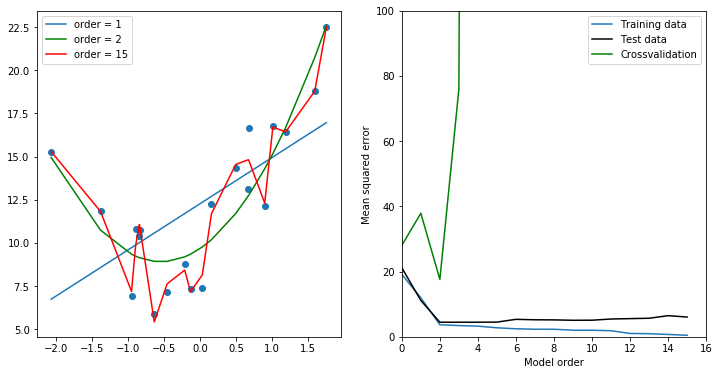

In [281]:
# Figure 1
# true model is quadratic (order 2)
# we generate data from this model and fit models of varying complexity

npts = 20 # number of data points
noise_sd = 2 # noise standard deviation

numpy.random.seed(123456) # set random seed for consistent data

x = numpy.random.randn(npts)
x = numpy.sort(x,axis=None)
x = StandardScaler().fit_transform(x[:,numpy.newaxis])

X = PolynomialFeatures(degree=2).fit_transform(x)
beta=[10,3,3]
Y_train = X.dot(beta) + numpy.random.randn(npts)*noise_sd
Y_test = X.dot(beta) + numpy.random.randn(npts)*noise_sd

coefs={}
model_order_range = 16
mse={'train':numpy.zeros(model_order_range),
    'test':numpy.zeros(model_order_range),
    'cv':numpy.zeros(model_order_range)}

lm = {}
model_X = {}
cv_results = {}

for model_order in range(model_order_range):
    model_X[model_order] = PolynomialFeatures(degree=model_order).fit_transform(x)
    lm[model_order] = LinearRegression(fit_intercept=False)
    lm[model_order].fit(model_X[model_order],Y_train)
    coefs[model_order]=lm[model_order].coef_
    mse['train'][model_order]=numpy.mean((Y_train - lm[model_order].predict(model_X[model_order]))**2)
    mse['test'][model_order]=numpy.mean((Y_test - lm[model_order].predict(model_X[model_order]))**2)
    
    # also compute cross-validation score
    cv_results[model_order] = model_selection.cross_validate(LinearRegression(fit_intercept=False),
                                               model_X[model_order],
                                               Y_train,cv=4,
                                               scoring='neg_mean_squared_error',
                                               return_train_score=False)
    mse['cv'][model_order] = -1*numpy.mean(cv_results[model_order]['test_score'])
   
# plot data points vs model fits

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x,Y_train)
plt.plot(x,lm[1].predict(model_X[1]))
plt.plot(x,lm[2].predict(model_X[2]),color='g')
plt.plot(x,lm[15].predict(model_X[15]),color='r')
plt.legend(['order = 1','order = 2','order = 15'])
# perform crossvalidation to estimate out-of-sample fit


# plot MSE

plt.subplot(1,2,2)
plt.plot(mse['train'])
plt.plot(mse['test'],color='k')
plt.plot(mse['cv'],color='g')
plt.axis([0,model_order_range,0,100])
plt.ylabel('Mean squared error')
plt.xlabel('Model order')
plt.legend(['Training data','Test data','Crossvalidation'])

*Figure 1*: A depiction of overfitting.  Left: A simulated dataset generated from a quadratic model (i.e., polynomial order = 2), shown in blue dots.  The best fitting models are shown with order 1 (linear; blue), order 2 (quadratic; green), and order 15 (red).  The complex model clearly overfits the dataset, adapting itself to the specific datapoints.  Right: The mean squared error (MSE) for the model assessed against the dataset used to train the model (blue), and against a separate dataset sampled from the same generative process with different random measurement error (black).  The MSE decreases for the training dataset as the complexity increases, whereas for the test dataset the MSE is lowest for order = 2 (i.e. the true model).  The MSE estimated using cross validation (green) is also lowest for the true model; note that it takes very large values for model orders greater than 3, falling outside the axes of the chart.

Because we don't generally have a separate test dataset to assess the generalization of our nodel, the standard approach in machine learning to address overfitting is to assess model fit using *crossvalidation*, which uses subsets of the data to iteratively train and test the predictive performance of the model.  The most common crossvalidation approach is known as k-fold crossvalidation, in which the data are split into k different subsets, and the model is successively trained on the remainder of the data (leaving out each subset) and then testing the predictive performance of the model on the held-out subset.  As shown in Figure 1, this approach can also help discover the model that will provide the best predictive performance on other data.

#### How optimistic are in-sample model fits?



As shown above, it is very common for investigators to report estimates of in-sample model fit in service of claims about "prediction". However, the concept of overfitting (and the related concept of "shrinkage" - Copas REF) suggests that any model is likely to fit better to the dataset used to estimate the model, compared to a new dataset sampled from the same population.  This means that any estimate of model fit obtained from a dataset will be an overly optimistic estimate of the true predictive accuracy on a new dataset.  

The left panel of Figure 2 shows an example of how the optimism of in-sample fits depends on the nature of the statistical model -- in this case, we use a simple linear model but vary the number of irrelevant independent variables in the model. As the number of variables increases, the fit of the model to the sample increases, due to overfitting.  Even for a single variable, the fit of the model is inflated compared to new data or crossvalidation, which provide very similar estimates of out-of-sample predictive accuracy.  The optimism of in-sample fits is also a function of sample size, as shown in the right panel of Figure 2.  

In [277]:
## Simulate optimism as a function of model size

def logistic_simulation(npts = 100, p_disease = 0.5,
                        nvars = 40, noise_sd = 2.5,
                        betaval=2,cv=4):
    # design matrix
    # first column reflects healthy (0) vs disease (1)
    # remaining columns are random noise
    X = numpy.zeros((npts,1))
    X[:int(npts*p_disease)]=1
    X = X - numpy.mean(X)
    if nvars > 1:
        noise = numpy.random.randn(npts*(nvars-1)).reshape((npts,nvars-1))
        noise = StandardScaler().fit_transform(noise)
        X = numpy.hstack((X,noise))
    betas = numpy.zeros(nvars)

    # only the disease variable has true relationship
    betas[0] = betaval
    Y = X.dot(betas) + numpy.random.randn(npts)*noise_sd
    Y = (Y > 0).astype('int')

    # create a new dataset to compare to CV
    Y_new = X.dot(betas) + numpy.random.randn(npts)*noise_sd
    Y_new = (Y_new > 0).astype('int')


    acc = {'insample':numpy.zeros(nvars),
           'newdata':numpy.zeros(nvars),
           'cv':numpy.zeros(nvars)}


    lr = LogisticRegression()

    for i in range(nvars):
        X_i = X[:,:(i+1)]
        lr.fit(X_i,Y)
        acc['insample'][i] = metrics.accuracy_score(Y,lr.predict(X_i))
        acc['newdata'][i] = metrics.accuracy_score(Y_new,lr.predict(X_i))

        cv_results = model_selection.cross_validate(LogisticRegression(),
                                                   X_i,
                                                   Y,cv=cv,
                                                   scoring='accuracy',
                                                   return_train_score=False)
        acc['cv'][i] = numpy.mean(cv_results['test_score'])

    return(acc)



In [278]:
acc_estimates = []
nruns = 100
for i in range(nruns):
    acc_estimates.append(logistic_simulation())
    
# summarize accuracy data
acc = {'insample':[],
        'newdata':[],
        'cv':[]}


for i in range(len(acc_estimates)):
    for k in acc:
        if i == 0:
            acc[k] = acc_estimates[i][k]
        else:
            acc[k] = numpy.vstack((acc[k],acc_estimates[i][k]))

for k in acc:
    acc[k] = numpy.mean(acc[k],0)



In [288]:
# simulate overfitting as a function of sample size, with just a single variable.

acc_estimates_sampsize = {}
nruns = 1000
sampsizes = 2**numpy.arange(5,10)
nvars = 5 # number of variables in simulation

for i,sampsize in enumerate(sampsizes):
    acc_estimates_sampsize[sampsize] = []
    for j in range(nruns):
        acc_estimates_sampsize[sampsize].append(logistic_simulation(npts=sampsize,
                                                                nvars=nvars))
        
# summarize sample size data
acc_sampsize = {'insample':numpy.zeros((nruns,len(sampsizes))),
        'newdata':numpy.zeros((nruns,len(sampsizes))),
        'cv':numpy.zeros((nruns,len(sampsizes)))}


for i in range(nruns): # simulations
    for j,sampsize in enumerate(sampsizes): # sample sizes
        for k in acc_sampsize: # measures 
            acc_sampsize[k][i,j] = acc_estimates_sampsize[sampsize][i][k][0]

for k in acc:
    acc_sampsize[k] = numpy.mean(acc_sampsize[k],0)



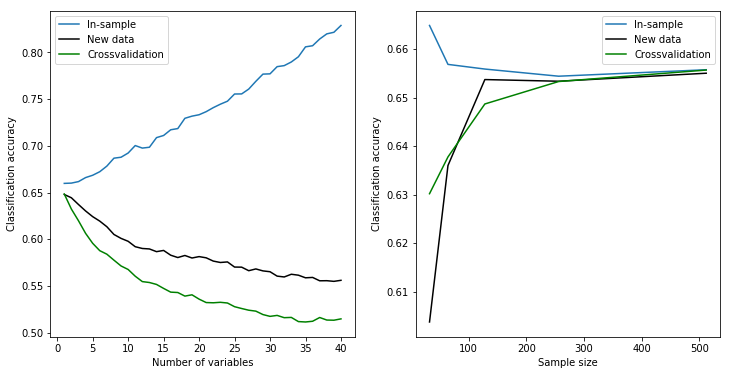

In [289]:

# make figure
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(numpy.arange(1,nvars+1),acc['insample'])
plt.plot(numpy.arange(1,nvars+1),acc['newdata'],'k')
plt.plot(numpy.arange(1,nvars+1),acc['cv'],'g')
plt.ylabel('Classification accuracy')
plt.xlabel('Number of variables')
plt.legend(['In-sample','New data','Crossvalidation'])




# plot sample size data
plt.subplot(1,2,2)
plt.plot(sampsizes,acc_sampsize['insample'])
plt.plot(sampsizes,acc_sampsize['newdata'],'k')
plt.plot(sampsizes,acc_sampsize['cv'],'g')
plt.ylabel('Classification accuracy')
plt.xlabel('Sample size')
plt.legend(['In-sample','New data','Crossvalidation'])



*Figure 2*: Left panel: Classification accuracy as a function of the number of variables in the model.  The data were generated using a single variable (which is the first variable in the list of variables); the remaining variables were simply random normal variables with no intended relationship to the outcome.  The blue line shows that in-sample classification accuracy is heavily inflated by the presence of unrelated variables in the model, due to the fitting of noise in those variables. The black line shows the results for testing the fitted model to a new dataset generated in the same way, and the green line shows the accuracy results using crossvalidation.  Crossvalidation prevents the inflated estimate of prediction accuracy, providing an estimate that is much more similar to that expected with a new dataset.  Right panel: Classification accuracy for the model with 5 variables (1 true generating variable and 4 noise variables) as a function of sample size.  Optimism (the difference between in accuracy between in-sample and crossvalidated/new data accuracy) is substantially higher for smaller sample sizes. 

#### Quantifying classification accuracy

In a classification problem, we wish to quantify our ability to accurately predict class membership, such as the presence of a disease or a cognitive state.  When the number of members in each class is equal, then average accuracy (i.e. the proportion of correct classifications, as used in the examples in Figure 2) is a reasonable measure of predictive accuracy.  However, if there is any imbalance between the categories, then this is a misleading measure, since above-chance accuracy could be obtained simply by predicting that all data points fall into the more common class, which is what a number of common classifiers will do in such a situation.

It is best practice to always use an accuracy measure that it robust to class imbalance, to avoid any potential problems in cases where imbalance occurs.  A simple measure is the *balanced accuracy*:

**balanced acc equation here**

**discuss ROC curves?**



#### Quantifying predictive accuracy for continuous variables

It is increasingly common to apply predictive modeling in cases where the outcome variable is continuous rather than discrete -- that is, in regression rather than classification problems.  A commonly used measure of predictive accuracy in this context is the amount of variance accounted for in the outcome measure, known as *r-squared*.  This measure has the benefit of being highly interpretable



This function will perform a single run of the simulation, creating a random dataset and estimating predictive performance using several different cross-validation methods:

- Leave-one-out
- Split-half (i.e. K-fold where K=2) 
- Split-half using balanced cross validation, which tries to equate the distributions of Y values across the different folds.


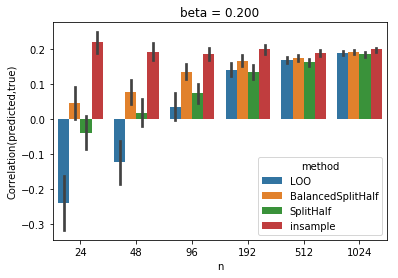

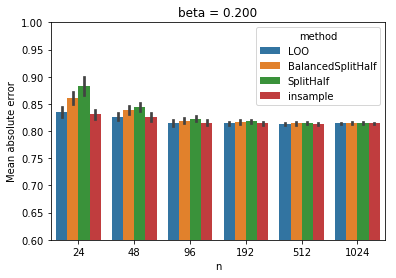

In [4]:
def cvtest(nsubs,cv_fns=None,beta=0.2,
           scale_X=True,scale_Y=True,
          scale_within_loop=False):
    """
    - function to perform a single simulation run
    nsubs: number of subjects per simulation
    cv_fns: dict of CV functions
    beta: strength of true relationship
    measure: 'corr': correlation, 'MAE': mean absolute error
    """
    results_corr=[]
    results_mae=[]
    
    if cv_fns is None:
        cv_fns={'LOO':model_selection.LeaveOneOut(),
               'BalancedSplitHalf':BalancedKFold(nfolds=2,pthresh=0.99),
               'SplitHalf':model_selection.KFold(n_splits=2,shuffle=True)}

    # just use simple linear regression
    clf=LinearRegression()
    
    # create random X and Y variables
    X=numpy.random.randn(nsubs).reshape((nsubs,1))
    if scale_X:
        X = (X - numpy.mean(X))/numpy.std(X)
    Y=numpy.random.randn(nsubs).reshape((nsubs,1)) + X*beta
    if scale_Y:
        Y = (Y - numpy.mean(Y))/numpy.std(Y)

    scaler=StandardScaler()
    # first run leave-one-out CV
    for method in cv_fns:
        cv=cv_fns[method]
        pred=numpy.zeros((nsubs,1))
        for train_index, test_index in cv.split(X,Y):

            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scale_within_loop:
                X_train=scaler.fit_transform(X_train)
                X_test=scaler.transform(X_test)
            clf.fit(X_train,y_train)

            pred[test_index,0]=clf.predict(X_test)[:,0]
        corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
        MAE=numpy.mean(numpy.abs(pred-Y[:,0]))
        results_corr.append([method,corr])
        results_mae.append([method,MAE])
    # also include in-sample
    clf.fit(X,Y)
    pred=clf.predict(X)
    corr=numpy.corrcoef(pred[:,0],Y[:,0])[0,1]
    MAE=numpy.mean(numpy.abs(pred-Y[:,0]))
    results_corr.append(['insample',corr])
    results_mae.append(['insample',MAE])
    return(results_corr,results_mae)
    
def plot_results(results,beta,measure):
    plt.figure()
    results_df = pandas.DataFrame(results,columns=['n','method',measure])
    seaborn.barplot(x='n',y=measure,hue='method',data=results_df)
    plt.title('beta = %0.3f'%beta)
    if measure=='MAE':
        plt.ylim((0.6,1.0))
        plt.ylabel('Mean absolute error')
    elif measure=='corr':
        plt.ylabel('Correlation(predicted,true)')
 

def run_sim(nruns,beta):
    results_corr=[]
    results_mae=[]
    for n in [24,48,96,192,512,1024]:
        for run in range(nruns):
            result_corr,result_mae=cvtest(n,beta=beta)
            for r in result_corr:
                results_corr.append([n]+r)
            for r in result_mae:
                results_mae.append([n]+r)
                
    return(results_corr,results_mae)

beta=.2
results_corr,results_mae=run_sim(nruns=100,beta=beta)
plt.figure(figsize=(10,6))
plot_results(results_corr,beta,'corr')
plt.savefig('corr_beta=.2.pdf')

plt.figure(figsize=(10,6))

plot_results(results_mae,beta,'MAE')
plt.savefig('mae_beta=.2.pdf')




When using correlation between predicted and actual values as our measure of peformance (top plot), we see that leave-one-out is systematically biased in the negative direction, especially at small sample sizes.  Split-half is biased to a lesser extent, and balanced split-half performs better, again seen mostly at smaller sample sizes.  At sample sizes of 512 and above, all of the crossvalidation methods are roughly equivalent, each showing a slight degrement compared to in-sample results (i.e. "shrinkage"). 

This problem does not occur when using mean absolute error as the performance measure (bottom plot).  In that case, split half performs poorly compared to LOO and balanced split-half which are roughly equivalent.

Now let's see what it looks like when there is no true signal (beta=0). 

In [ ]:
beta=0.
results_corr,results_mae=run_sim(nruns=100,beta=beta)
plot_results(results_corr,beta,'corr')
plot_results(results_mae,beta,'MAE')



Here we see that leave-one-out is badly biased in the negative direction, whereas in-sample prediction is biased in the positive direction.  Balanced split-half is the only method is consistently unbiased across all sample sizes.

Two takeaway messages from this:

- r-squared is a particularly bad metric for quantifying predictive accuracy in cross-validated regression
- cross-validation with small sample sizes is a really bad idea.

Now let's illustrate where this comes from. First we will generate some random X and Y variables with a moderate correlation.

In [ ]:
good_data=False
nsubs=24
beta=0.3
numpy.random.seed(123456)
X=numpy.random.randn(nsubs).reshape(nsubs,1)
Y=numpy.random.randn(nsubs).reshape(nsubs,1) + X*beta

Y = (Y - numpy.mean(Y))/numpy.std(Y)
X = (X - numpy.mean(X))/numpy.std(X)

print('cor(X,Y):',numpy.corrcoef(X[:,0],Y[:,0])[0,1])
plt.scatter(X,Y)

Let's first compute the linear relation using the full dataset.

In [99]:
lm_full=LinearRegression()
lm_full.fit(X,Y)
print(lm_full.coef_)

[ 0.27286845]


Now let's do leave-one-out crossvalidation and see what happens to the predicted regression coefficient on each fold.

In [104]:
cv=model_selection.LeaveOneOut()
pred=numpy.zeros(X.shape[0])
coef=numpy.zeros(X.shape[0])

for train_index, test_index in cv.split(X,Y):            
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = Y[train_index,0], Y[test_index,0]
    lm_full.fit(X_train,y_train)
    pred[test_index]=lm_full.predict(X_test)
    coef[test_index]=lm_full.coef_[0]
abserr=numpy.abs(pred-Y.T)

In [105]:
numpy.corrcoef(pred,Y.T)

array([[ 1.        ,  0.00906506],
       [ 0.00906506,  1.        ]])

As expected, the out-of-sample prediction accuracy is basically zero.

Now let's plot the relationship between the predicted and actual values see if we can get any insight.

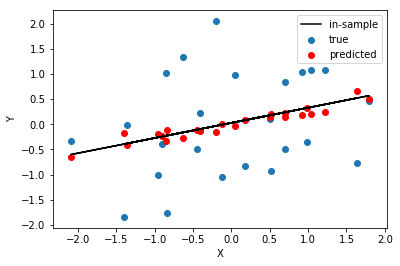

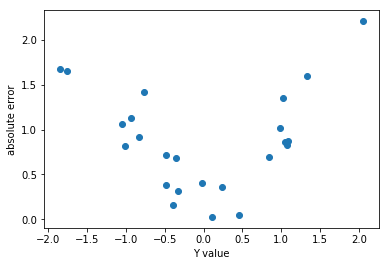

In [106]:

plt.scatter(X,Y,label='true')
plt.scatter(X,pred,color='r',label='predicted')
x = numpy.array([min(X),max(X)])
plt.plot(X,lm_full.predict(X), c="black", label="in-sample")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

#for i in range(len(X)):
plt.figure()
plt.scatter(Y,abserr)
plt.ylabel('absolute error')
plt.xlabel('Y value')


There is a strong negative relationship between error and Y value - large positive Y values show large negative errors, and large negative Y values show large positive errors.  This reflects the fact that when a large positive Y value is left out, the regression line will shift in the other direction.